In [29]:
from typing import List
import pandas as pd 
import plotly.graph_objects as go
import sys
import redis
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import QuantLib as ql
from datetime import datetime
import json


In [30]:
sys.path.append('..')

In [31]:
from src.kata_alpaca_engine.ingestion_engine import RedisTableUtility
from src.kata_models.GaussianProcessModel import RegressionModel

In [32]:
stock = '_NVDA'
date = '2024-01-04/present'

In [33]:
connection = redis.Redis(host='red', port=6379)

In [34]:
rt_utils = RedisTableUtility(connection)

In [35]:
df = rt_utils.get(stock, date)

In [36]:
# prepare data for modelling 

In [37]:
# need to write some preprocessing utils

In [38]:
timestamps = df['timestamp']

try: 
    datetime_array = np.array([datetime.strptime(date, '%Y-%m-%d %H:%M:%S') for date in timestamps])
except: 
    try:
        datetime_array = np.array([datetime.strptime(str(date), '%Y-%m-%dT%H:%M:%S.%f000000') for date in timestamps])
    except:
        datetime_array = np.array([datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S') for date in timestamps])


In [90]:
start_date = datetime_array[0]
days_array = np.array([(date - start_date).days for date in datetime_array])
days_array = days_array.astype('float64')
price = df['price'].values

In [91]:
model = RegressionModel(days_array, price)

In [92]:
model.fit()

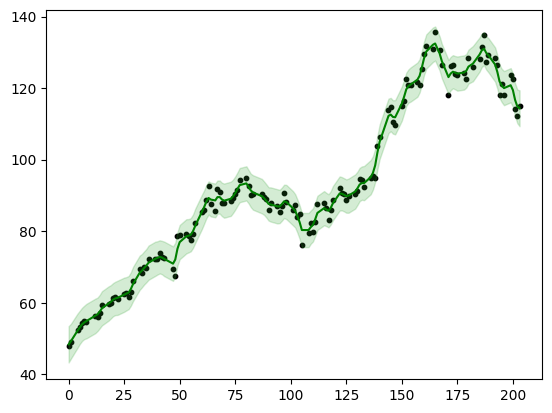

In [93]:
model.plot_train_data(clf=False)


In [94]:
model.predict();

In [95]:
def create_bands(yfit, sigma, bound_factor = 2.576):
    lower = yfit - sigma * bound_factor
    upper = yfit + sigma * bound_factor
    return lower, upper


lower, upper = create_bands(model.test_fit_y, model.test_fit_y_sigma)

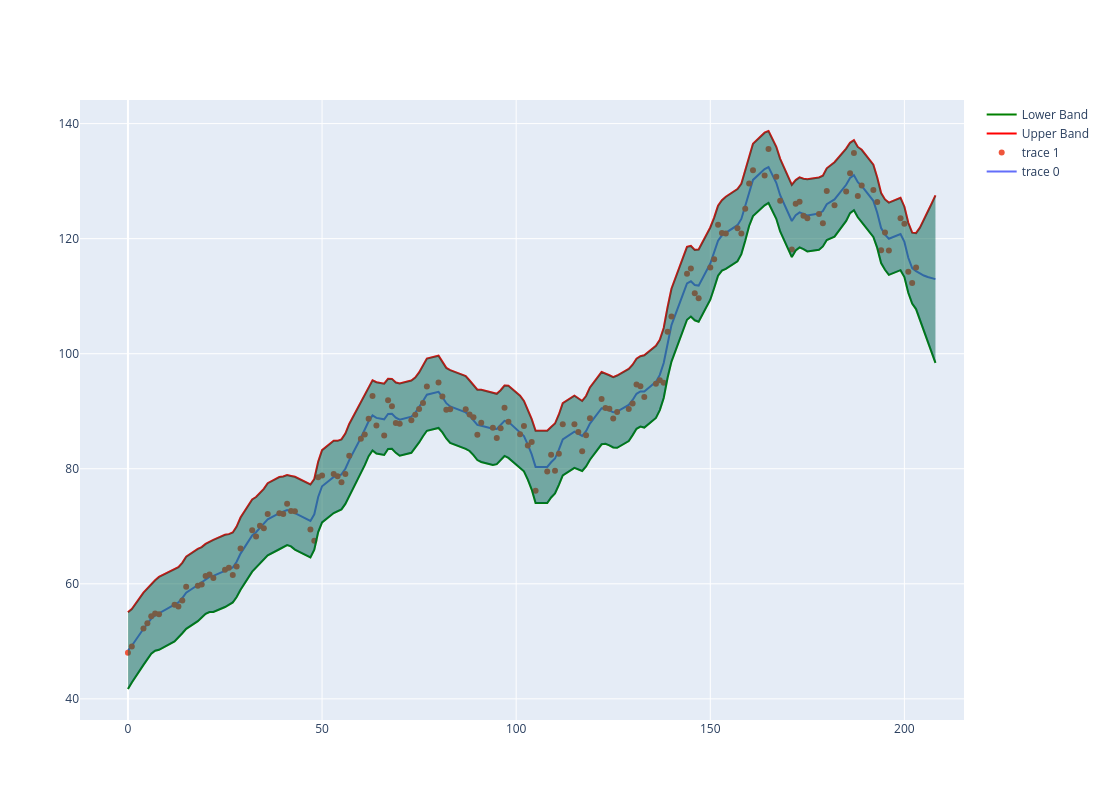

In [96]:
fig = go.Figure([go.Scatter(x=model.Xt, 
                            y=model.test_fit_y),
               go.Scatter(x=days_array, 
                            y=df['price'], mode='markers'),
            go.Scatter(x=model.Xt, y=upper, line=dict(color='red', width=2), name='Upper Band'),
            go.Scatter(x=model.Xt, y=lower, line=dict(color='green', width=2), name='Lower Band'),
            go.Scatter(x=model.Xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
            go.Scatter(x=model.Xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False)
                ])
fig.update_layout(width=1200, height=800)

fig.show()

In [97]:
start_date = datetime_array[0]
days_array = np.array([(date - start_date).days for date in datetime_array])
days_array_full = np.array([(date - start_date).days for date in datetime_array]).astype('float64')
days_array = days_array.astype('float64')
price = df['price'].values
model = RegressionModel(days_array, price)
model.band_factor = 3.291
model.fit()
model.predict()
lower, upper = create_bands(model.test_fit_y, model.test_fit_y_sigma, 3.291)

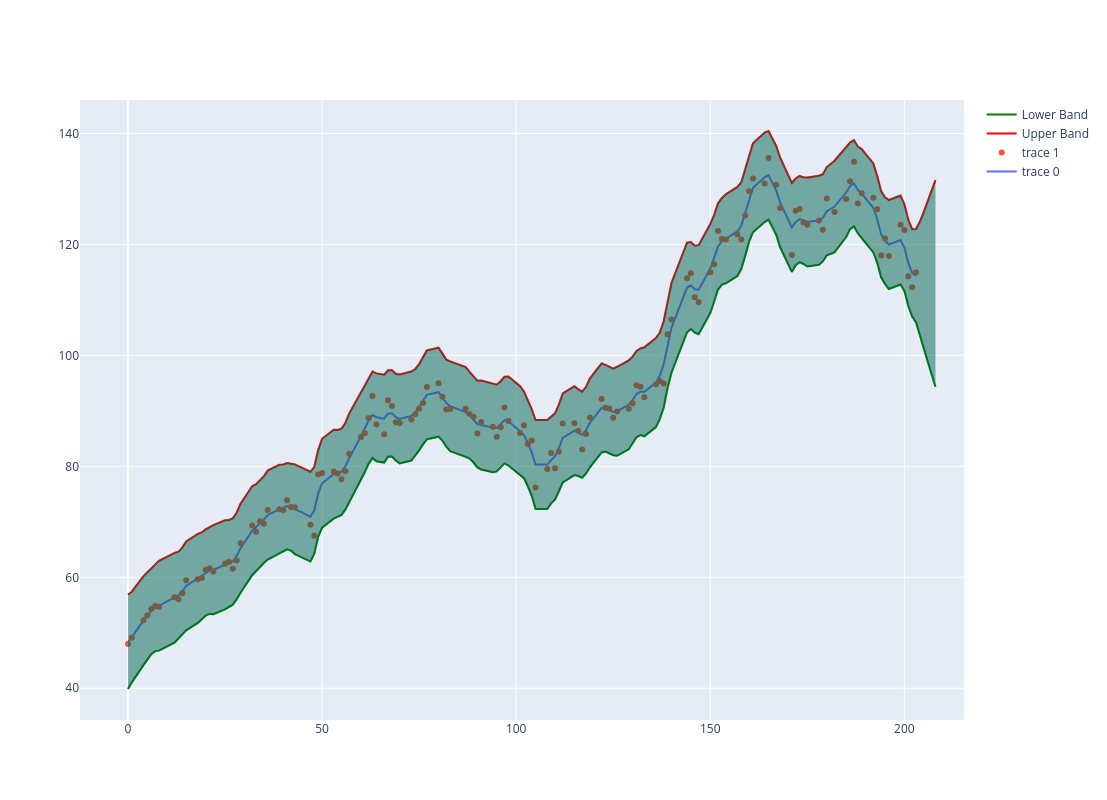

In [98]:
fig = go.Figure([go.Scatter(x=days_array, 
                            y=model.test_fit_y),
               go.Scatter(x=days_array_full, 
                            y=df['price'], mode='markers'),
            go.Scatter(x=model.Xt, y=upper, line=dict(color='red', width=2), name='Upper Band'),
            go.Scatter(x=model.Xt, y=lower, line=dict(color='green', width=2), name='Lower Band'),
            go.Scatter(x=model.Xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
            go.Scatter(x=model.Xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False)
                ])
fig.update_layout(width=1200, height=800)

fig.show()

In [99]:
# create test data. 

In [100]:
# create schedule 
# Set up the NYSE calendar
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

In [101]:
# create schedule 
# Set up the NYSE calendar
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)

end_date = ql.Date(2, 8, 2024)

def create_projections(end_date) -> List:
    # Define today's date and the end date
    today = ql.Date.todaysDate()
    
    # Generate business days
    business_days = []
    current_date = today
    
    while current_date <= end_date:
        if calendar.isBusinessDay(current_date):
            business_days.append(current_date)
        current_date = calendar.advance(current_date, ql.Period(1, ql.Days))
    
    # Convert QuantLib Dates to datetime objects
    business_days_datetime = [datetime(current_date.year(), current_date.month(), current_date.dayOfMonth()) for current_date in business_days]
    
    projected_datetimes = []
    # Print the datetime objects
    for dt in business_days_datetime:
        projected_datetimes.append(dt)
    return projected_datetimes

In [102]:
projected_dates = create_projections(end_date)

In [103]:
start_date = datetime(day=4,month=1,year=2024)

In [104]:
days_array = [float((proj - start_date).days) for proj in projected_dates]

In [105]:
model.predict(days_array)
lower, upper = create_bands(model.test_fit_y, model.test_fit_y_sigma, 3.291)

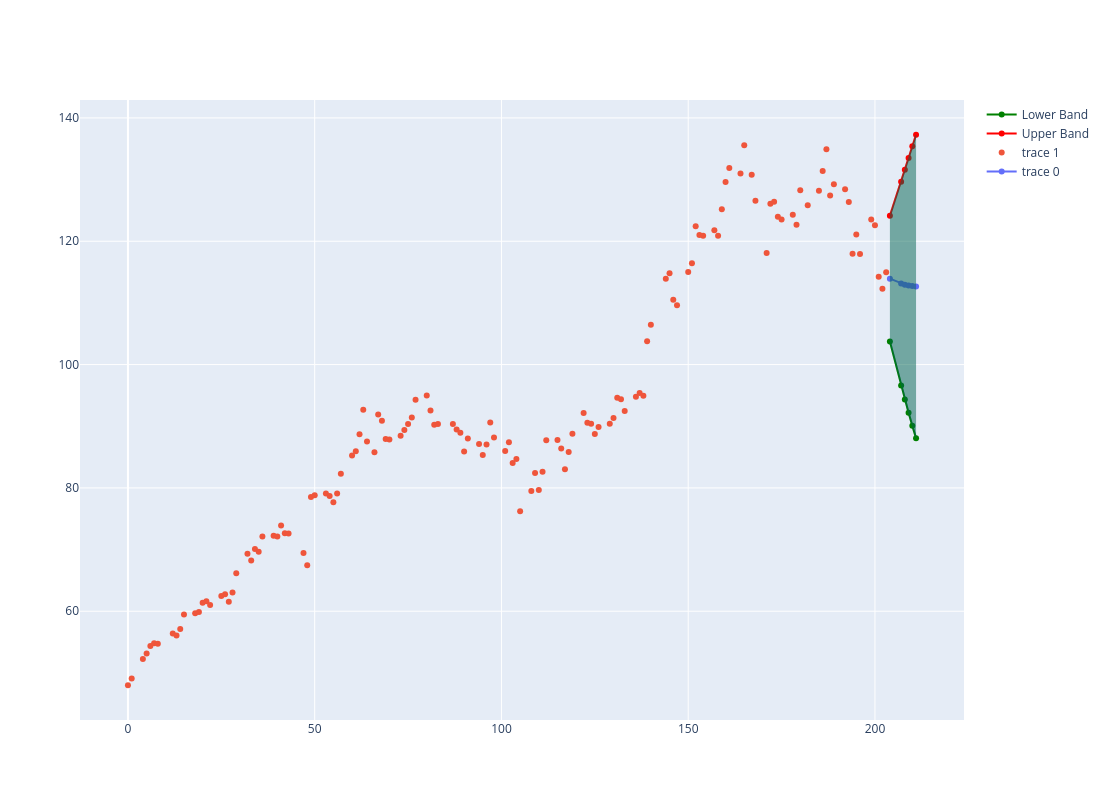

In [106]:
fig = go.Figure([go.Scatter(x=days_array, 
                            y=model.test_fit_y),
               go.Scatter(x=days_array_full, 
                            y=df['price'], mode='markers'),
            go.Scatter(x=model.Xt, y=upper, line=dict(color='red', width=2), name='Upper Band'),
            go.Scatter(x=model.Xt, y=lower, line=dict(color='green', width=2), name='Lower Band'),
            go.Scatter(x=model.Xt, y=upper, fill=None, mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False),
            go.Scatter(x=model.Xt, y=lower, fill='tonexty', mode='lines', line=dict(color='rgba(0,100,80,0.2)'), showlegend=False)
                ])
fig.update_layout(width=1200, height=800)

fig.show()

In [56]:
df_nvidia_special_dates = pd.DataFrame({'dates':
                                    ['2024-06-10',
                                    '2021-07-20',
                                    '2007-09-11',
                                    '2006-04-07'],
                                    'split':[
                                        10,
                                        4,
                                        2/3,
                                        2,
                                    ]
                                    })

In [57]:
df_nvidia_special_dates;

In [58]:
rt_utils.set('_NVDA_STOCK_SPLIT', '2024-07-26', df_inbound=df_nvidia_special_dates);

In [59]:
connection.set('_NVDA_KEYS', json.dumps(['_NVDA','_NVDA_STOCK_SPLIT']));